In [143]:
# Libraries
import numpy as np
import pandas as pd
import gym
from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib.tri import Triangulation
import seaborn as sns

# Pandas configuration
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sns.set_context("talk")

In [144]:
class QLearningAgent():

    def __init__(self, agent_init_info):
        """
        Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            alpha (float): The step-size,
            gamma (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.alpha = agent_init_info["alpha"]
        self.gamma = agent_init_info["gamma"]

        # Set Random Seed
        self.rand_generator = np.random.RandomState(0)
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.

        
    def agent_start(self, observation):
        """
        The first method called when the episode starts, called after
        the environment starts.
        Args:
            observation (int): the state observation from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        state = observation
        current_q = self.q[state,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, observation):
        """
        A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            observation (int): the state observation from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        # Choose action using epsilon greedy.
        state = observation
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # Perform an update
        self.q[self.prev_state, self.prev_action] += self.alpha * (reward + self.gamma * np.max(self.q[state, :]) - self.q[self.prev_state, self.prev_action])
        
        self.prev_state = state
        self.prev_action = action

        return action
    
    def agent_end(self, reward):
        """
        Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode
        self.q[self.prev_state, self.prev_action] += self.alpha * (reward- self.q[self.prev_state, self.prev_action])
        
    def argmax(self, q_values):
        """
        argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)


    def create_summary_table(self):
        """
        Create a pandas sumamry table based on agents q
        """
        df_sumamry = pd.DataFrame(agent.q)
        df_sumamry["optimal_action"] = agent.q.argmax(axis=1)
        df_sumamry["state_value"] = agent.q.max(axis=1)
        df_sumamry = df_sumamry.reset_index().rename(columns={"index":"state"})
        
        return df_sumamry
        

In [145]:
def plot_frozen_lake(df_summary):

    # Label dict
    direction_dict = {0:"←", 1:"↓", 2:"→", 3:"↑"}
    terminal_states = [5, 7, 11, 12, 15] 
    
    df_temp = df_summary.copy()

    df_temp["label"] = df_temp["optimal_action"].apply(lambda x: direction_dict[x])
    df_temp["x"] = df_temp["state"].apply(lambda x: x//4)
    df_temp["y"] = df_temp["state"].apply(lambda x: x%4)

    df_temp = df_temp[~df_temp["state"].isin(terminal_states)]

    # Reshape Data
    returns = df_temp.pivot("x", "y", "state_value")
    direction = df_temp.pivot("x", "y", "label")

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(16,7))
    fig.suptitle('State Values for Optimal Policy')

    sns.heatmap(returns, annot=True, linewidths=.5, cbar=False, cmap="Blues", ax=axes[0])
    sns.heatmap(returns, annot=np.array(direction), linewidths=.5, cbar=False, cmap="Blues", fmt = '', ax=axes[1])

In [146]:
def triangulation_for_triheatmap(M, N):
    xv, yv = np.meshgrid(np.arange(-0.5, M), np.arange(-0.5, N))  # vertices of the little squares
    xc, yc = np.meshgrid(np.arange(0, M), np.arange(0, N))  # centers of the little squares
    x = np.concatenate([xv.ravel(), xc.ravel()])
    y = np.concatenate([yv.ravel(), yc.ravel()])
    cstart = (M + 1) * (N + 1)  # indices of the centers

    trianglesN = [(i + j * (M + 1), i + 1 + j * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesE = [(i + 1 + j * (M + 1), i + 1 + (j + 1) * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesS = [(i + 1 + (j + 1) * (M + 1), i + (j + 1) * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesW = [(i + (j + 1) * (M + 1), i + j * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    return [Triangulation(x, y, triangles) for triangles in [trianglesN, trianglesE, trianglesS, trianglesW]]

def plot_state_action_frozen_lake(df_summary):

    direction_dict = {0:"←", 1:"↓", 2:"→", 3:"↑"}
    terminal_states = [5, 7, 11, 12, 15] 

    df_temp = df_summary.copy()

    df_temp["label"] = df_temp["optimal_action"].apply(lambda x: direction_dict[x])
    df_temp["x"] = df_temp["state"].apply(lambda x: x//4)
    df_temp["y"] = df_temp["state"].apply(lambda x: x%4)

    df_temp = df_temp[~df_temp["state"].isin(terminal_states)]
    df_temp = df_temp[["x","y",0,1,2,3]]

    df_piv = df_temp.pivot_table(index='x', columns='y')

    M = len(df_piv.columns) // 4
    N = len(df_piv)
    values = [df_piv[dir] for dir in
            [3, 2, 1, 0]]  # {0: '←', 1: '↓', 2: '→', 3: '↑'}

    triangul = triangulation_for_triheatmap(M, N)
    cmaps = ['Blues'] * 4

    norms = [plt.Normalize(0, 1) for _ in range(4)]
    fig, ax = plt.subplots(figsize=(16, 7))
    imgs = [ax.tripcolor(t, np.ravel(val), cmap=cmap, norm=norm, ec='white')
            for t, val, cmap, norm in zip(triangul, values, cmaps, norms)]


    for val, dir in zip(values, [(-1, 0), (0, 1), (1, 0), (0, -1)]):
        for i in range(M):
            for j in range(N):
                v = val[i][j]
                ax.text(i + 0.3 * dir[1], j + 0.3 * dir[0], f'{v:.2f}', color='k' if 0.2 < v < 0.8 else 'w', ha='center', va='center')

    ax.tick_params(length=0)
    ax.set_xticks(range(M))
    ax.set_xticklabels(df_piv[3].columns)
    ax.set_yticks(range(N))
    ax.set_yticklabels(df_piv.index)
    ax.invert_yaxis()
    ax.margins(x=0, y=0)

    ax.set_title("State-Action Values")

    plt.tight_layout()
    plt.show()

In [156]:
# Environment
env = gym.make("FrozenLake-v1")

# Parameters
epsilon = 0.05
alpha = 0.5
gamma = 0.99

# Number of runs and episodes per run
num_runs = 10
num_episodes = 10000

In [157]:
# Set random seed
np.random.seed(0)

# Agent information
agent_info = {"num_actions": env.action_space.n, 
              "num_states": env.observation_space.n, 
              "epsilon": epsilon, 
              "alpha": alpha, 
              "gamma": gamma}

# History
all_q = []

# Iterate
for _ in tqdm(range(num_runs)):
    
    # Initialize Agent
    agent = QLearningAgent(agent_info)

    for _ in range(num_episodes):

        # Reset env
        env.reset()
        state = env.s

        # Initial action
        action = agent.agent_start(state)
        done = False

        while not done:

            new_state, reward, done, _ = env.step(action)
            new_action = agent.agent_step(reward, new_state)

            # Update state and action
            state, action = new_state, new_action

        agent.agent_end(reward)

    # Append summary table
    all_q.append(agent.create_summary_table())

100%|██████████| 10/10 [02:41<00:00, 16.12s/it]


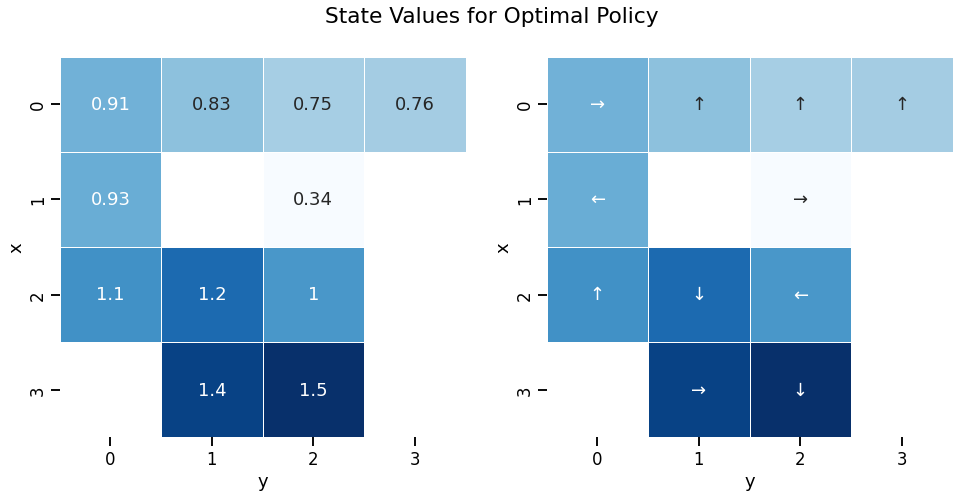

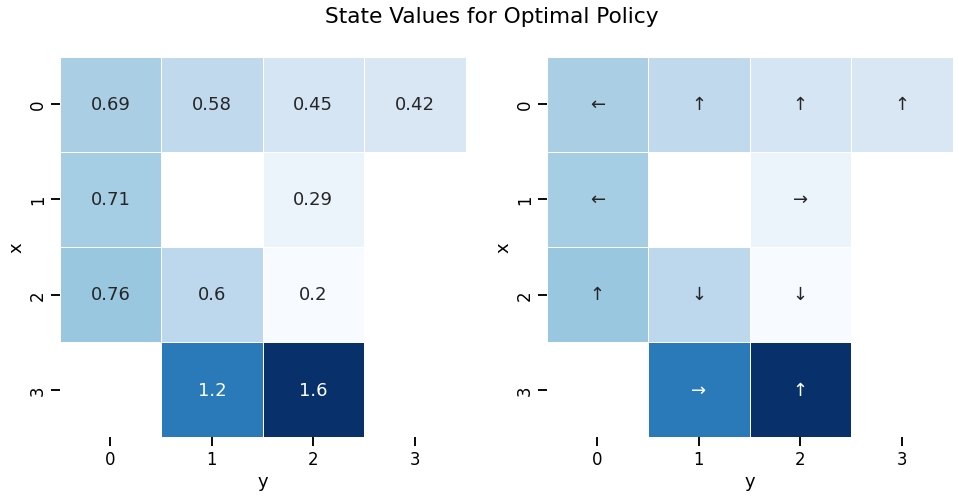

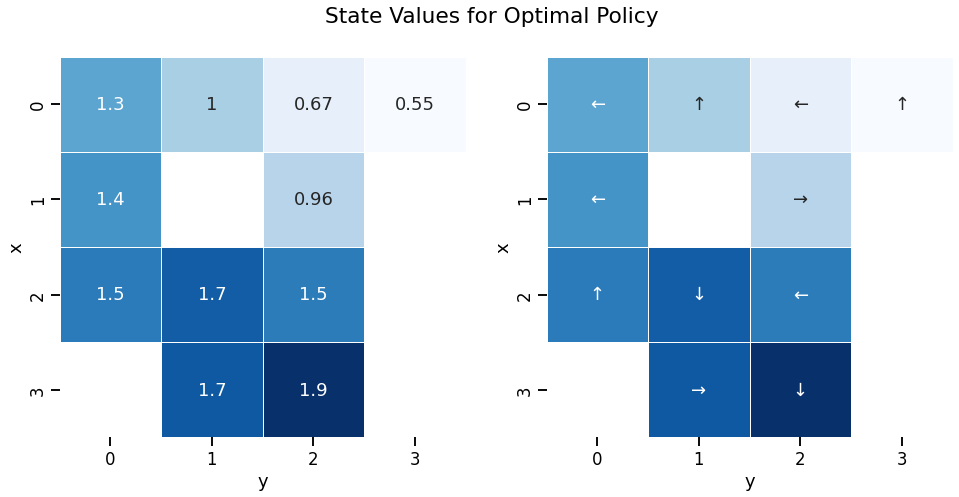

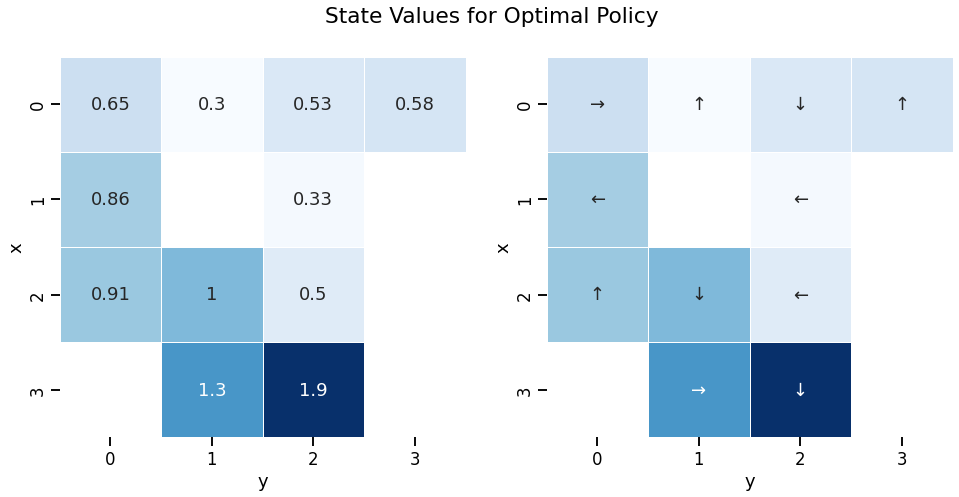

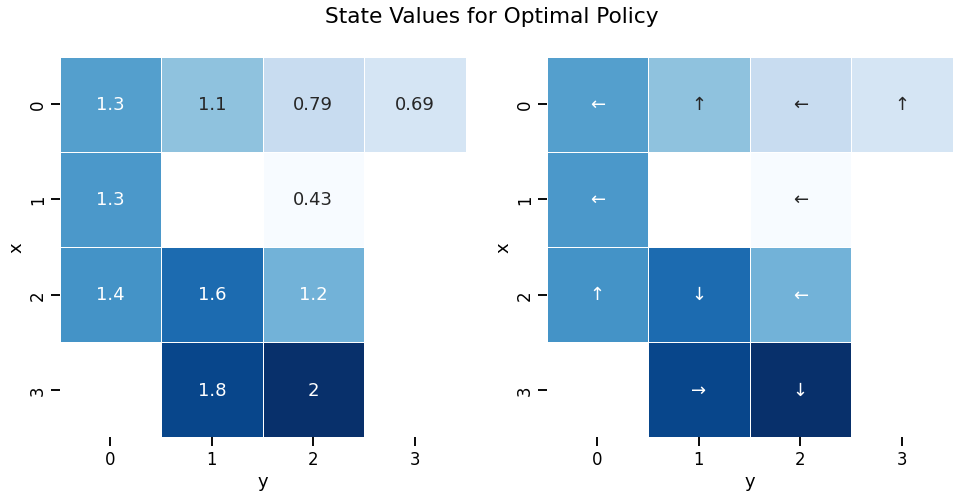

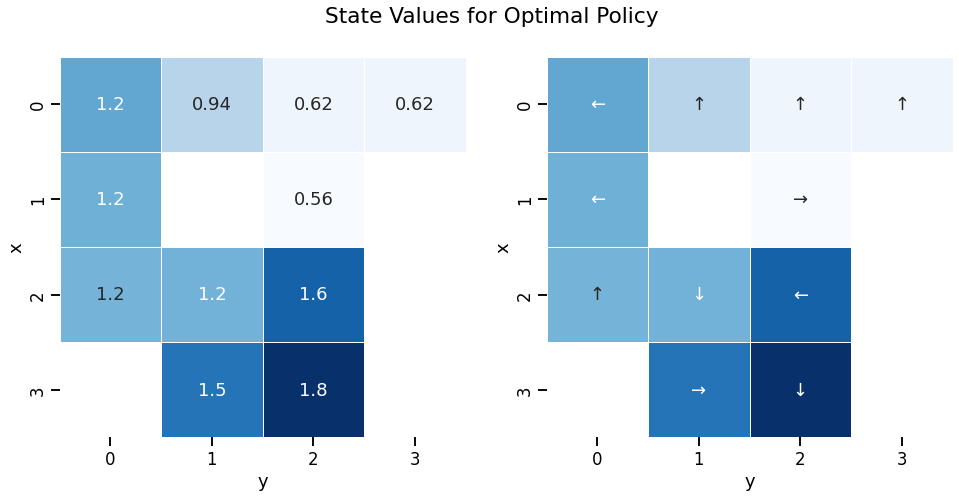

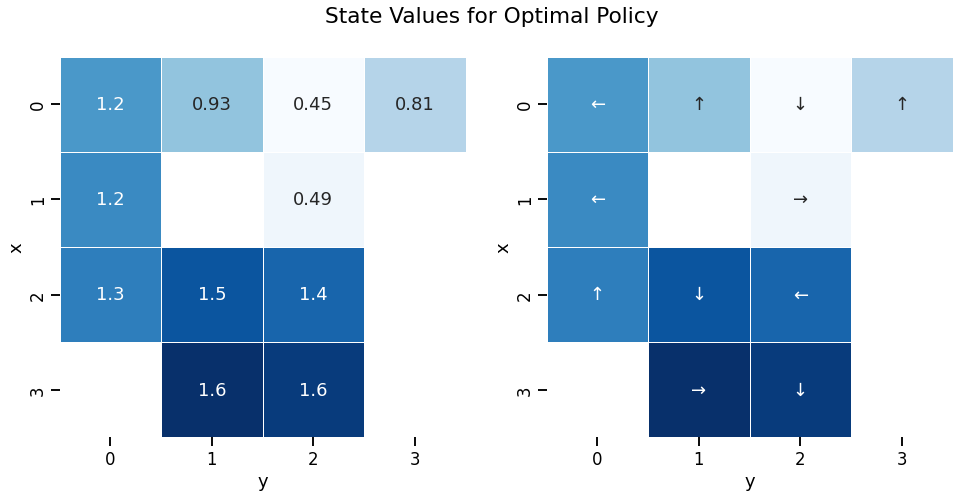

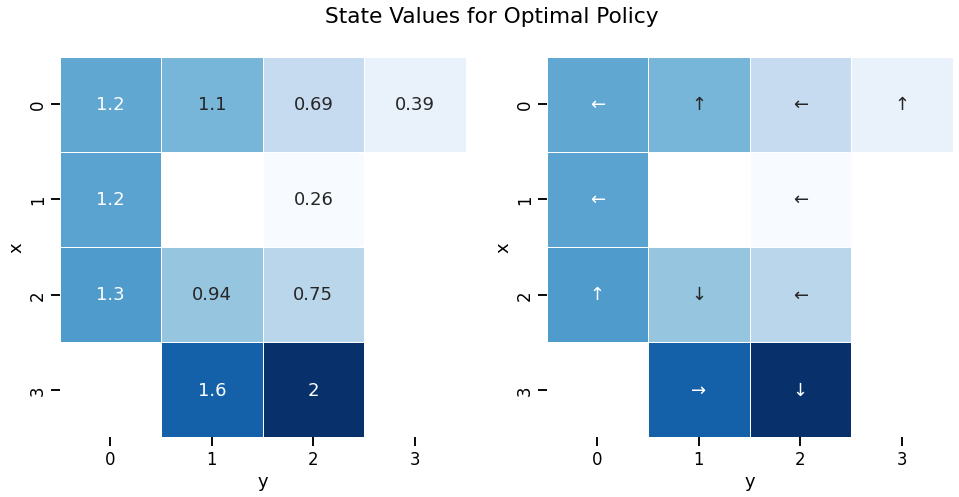

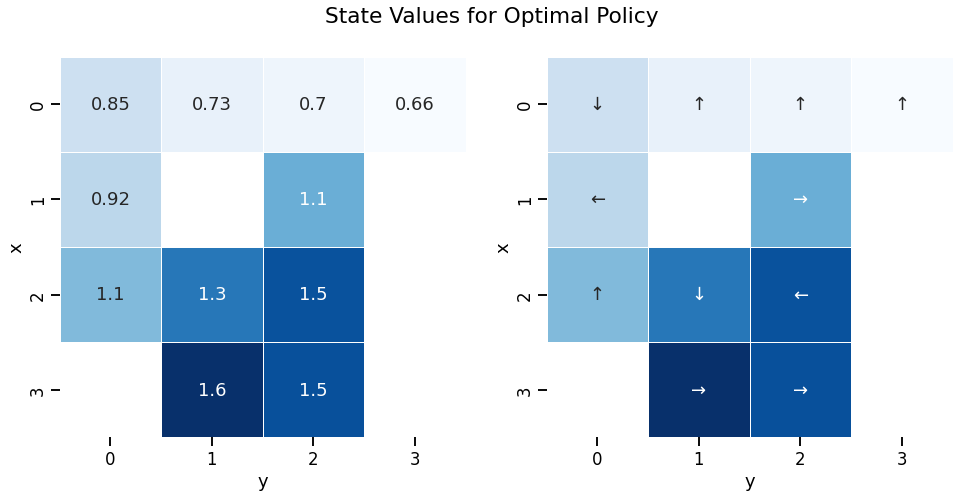

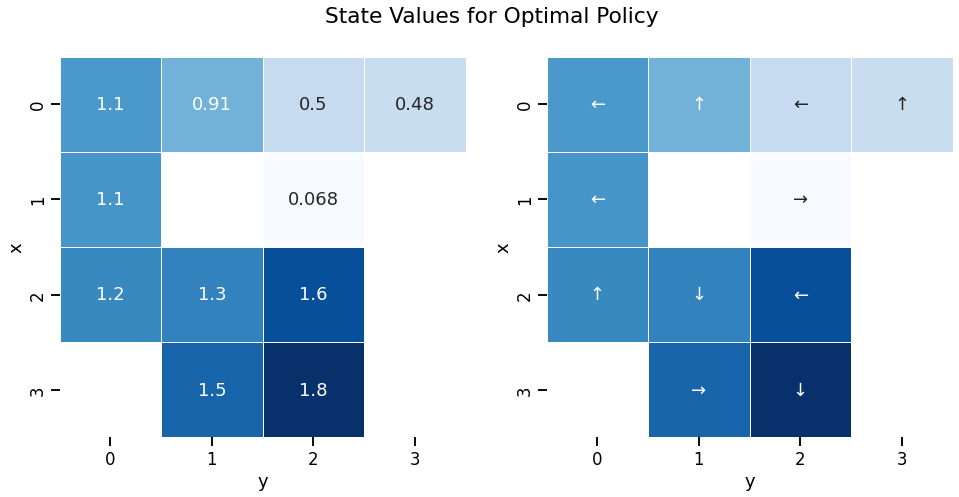

In [158]:
for i in range(10):
    plot_frozen_lake(all_q[i])

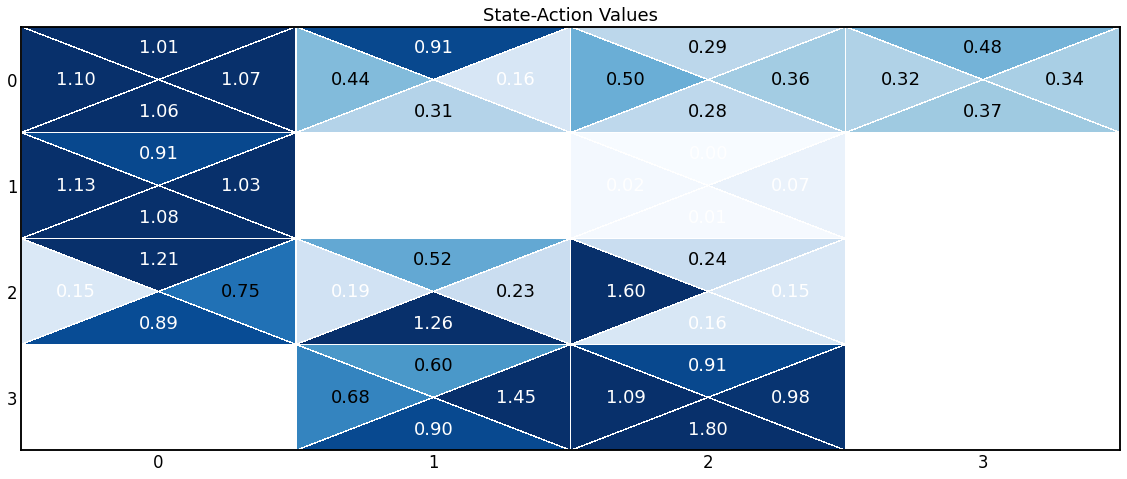

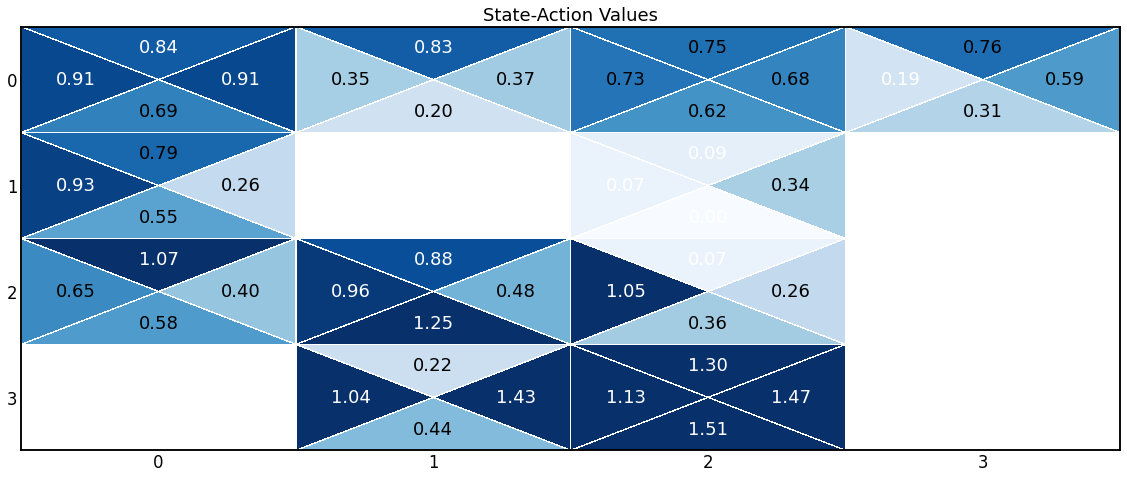

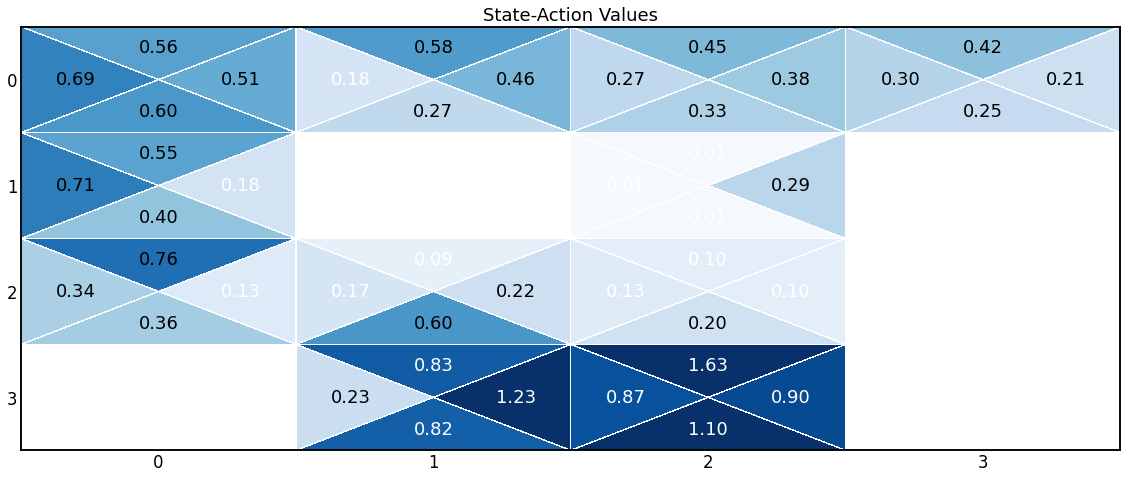

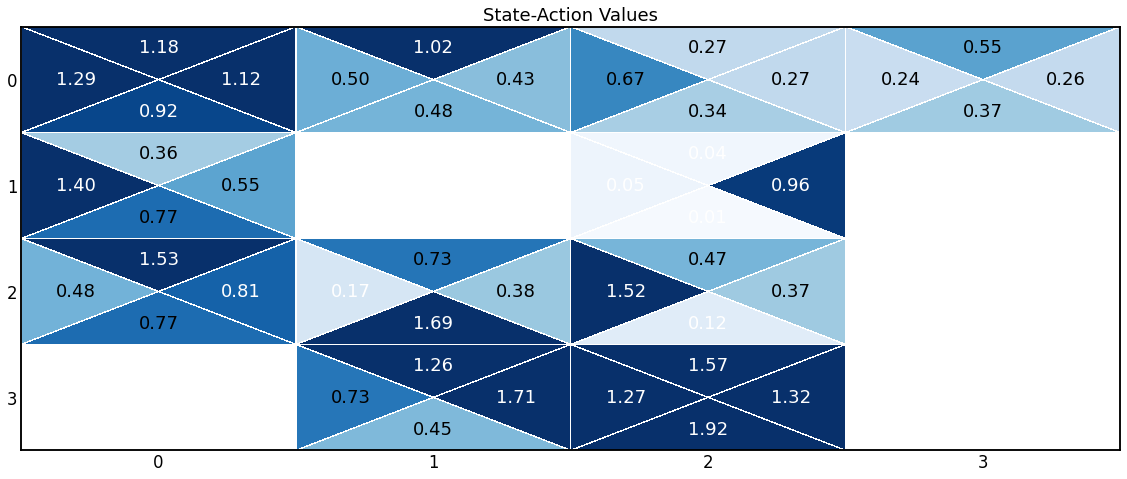

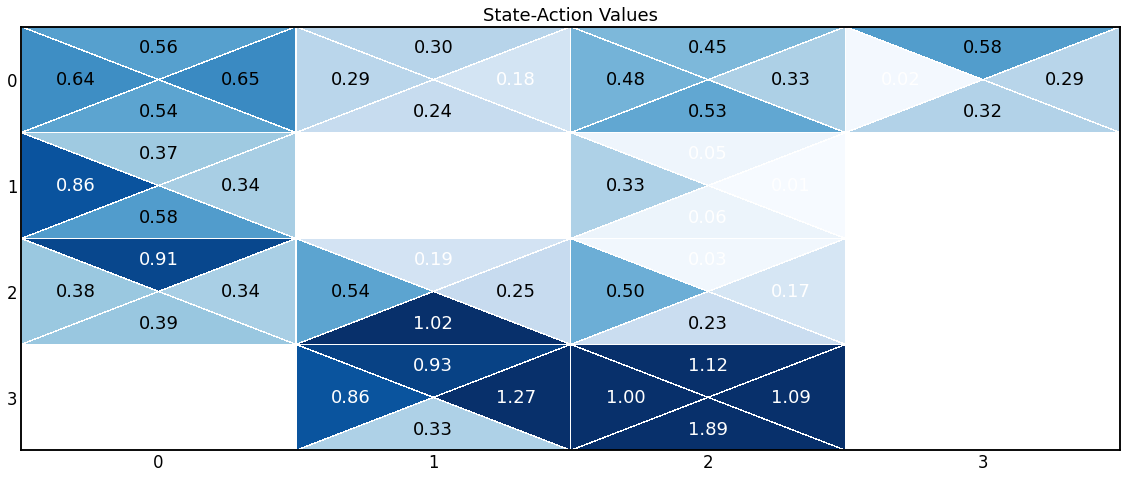

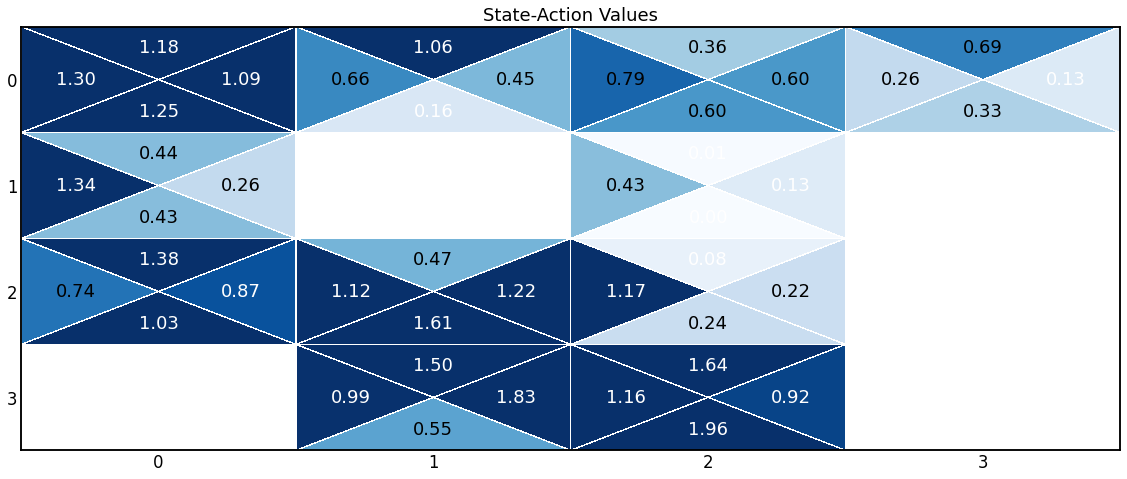

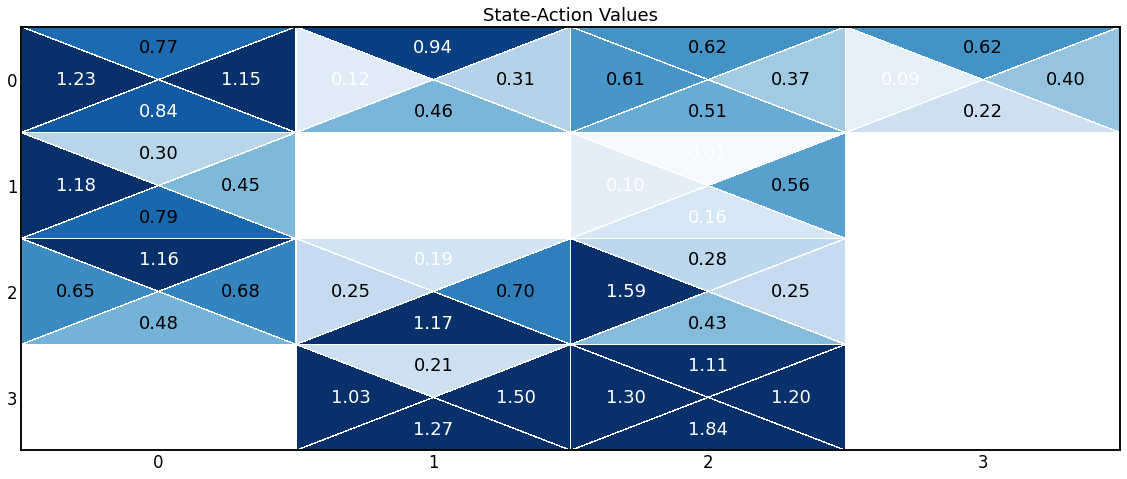

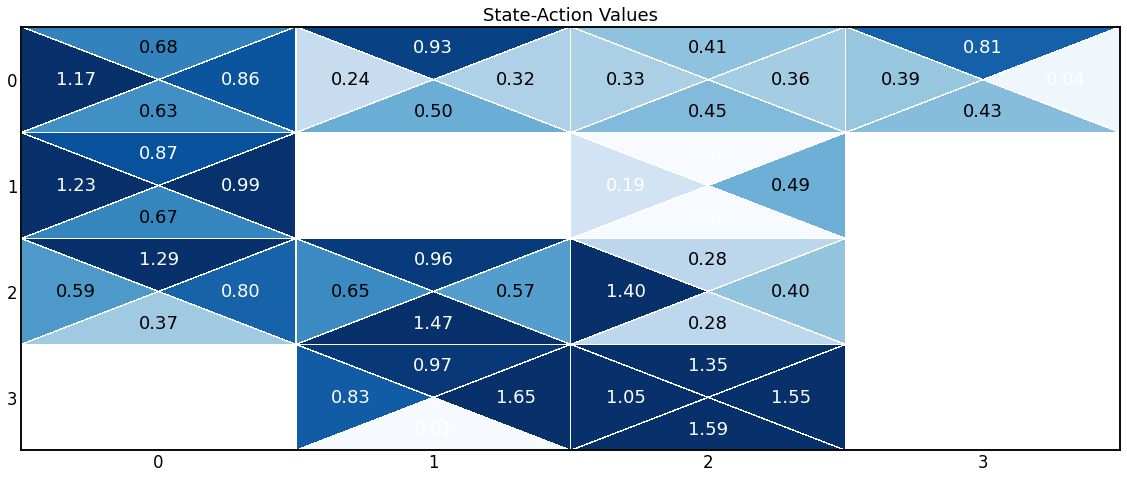

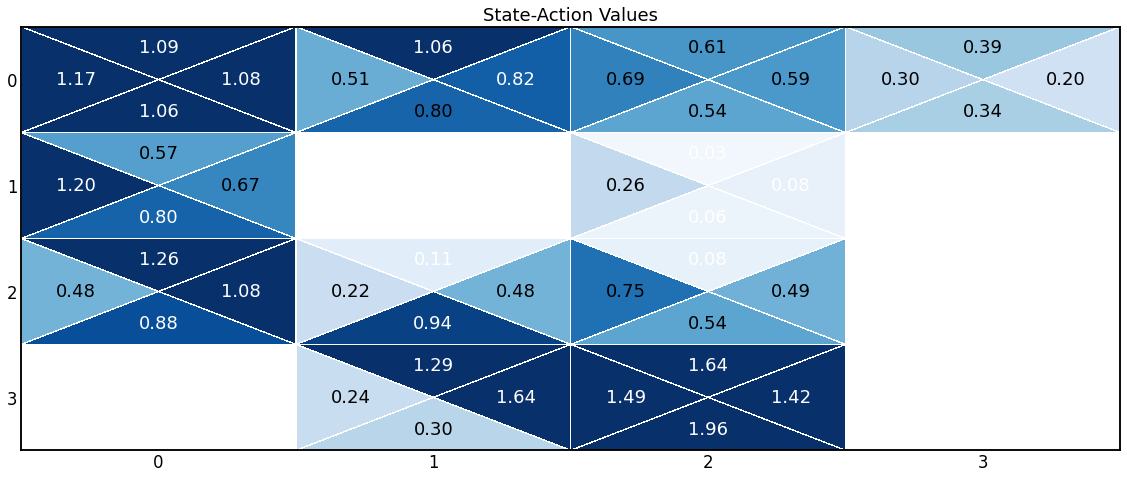

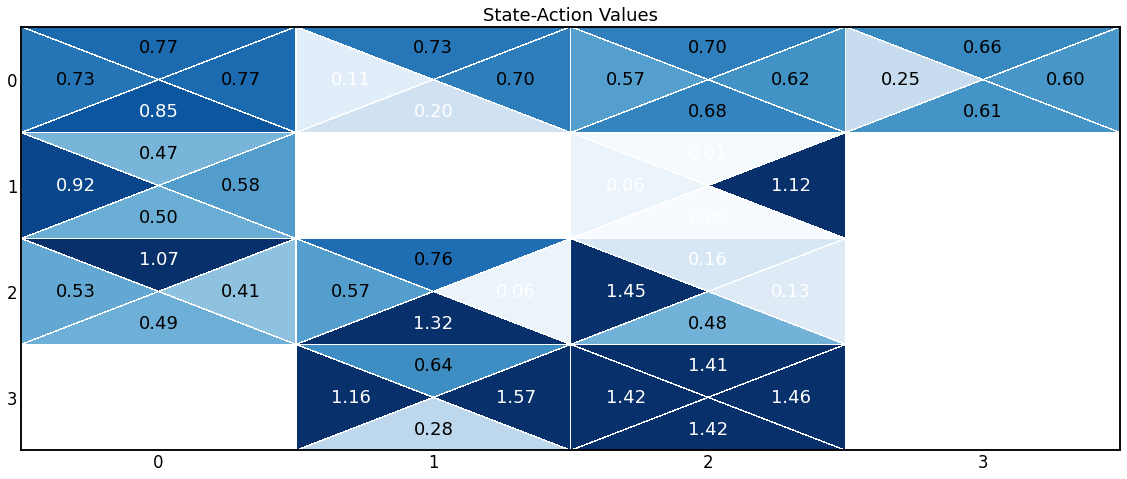

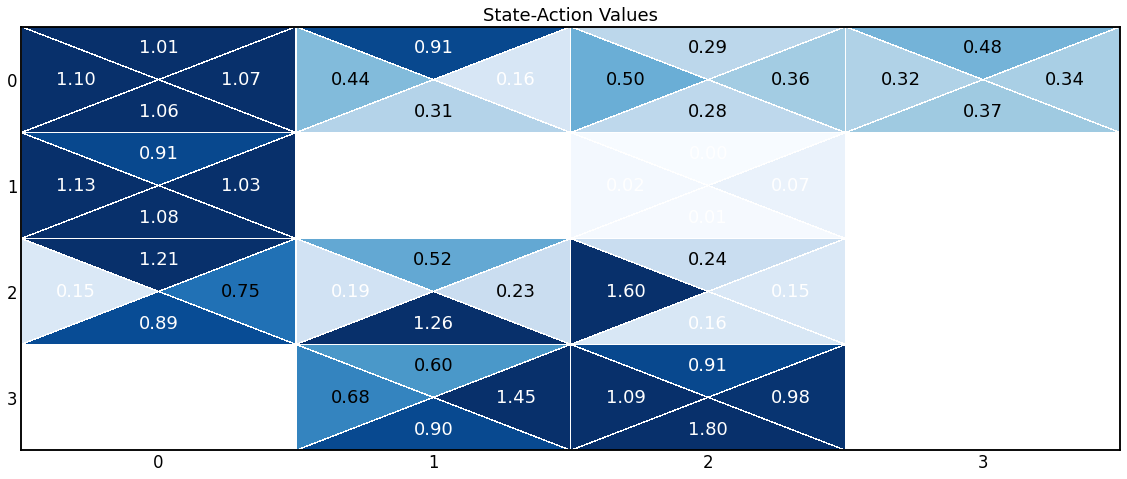

In [159]:
plot_state_action_frozen_lake(agent.create_summary_table())

for i in range(10):
    plot_state_action_frozen_lake(all_q[i])